# Ion switching challenge
In this challenge, we predict the number of open channels from signal data.
## Background
Electrophysiology is a field in science which deals with studying the changes in current flow within cells, tissues or organs. The patch_clamp_technique is an important technique in this field. 
* The patch_clamp technique uses a micropipette with a mm opening at one end. The pipette is attatched to a cell covering one or more channels.
* The pipette contain an electrolyte containing solution which may or may not contain same electrolytes as the cytosol 
* The electrolyte is connceted to an amplifier by an electrode. Changes in current when the channels open are recorded.

In [34]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import math
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from imblearn.over_sampling import SMOTE
%matplotlib inline
np.random.seed(42)

* Loading data and displaying a few rows to get an idea of our dataset

In [35]:
Train_path = os.path.join(
    '/Users/fritzpeleke/PycharmProjects/DeepLearn', 'liverpool-ion-switching', 'train.csv')
Test_path = os.path.join(
    '/Users/fritzpeleke/PycharmProjects/DeepLearn', 'liverpool-ion-switching', 'test.csv')
data = pd.read_csv(Train_path)
print(data.head())
Test_data = pd.read_csv(Test_path)
print(Test_data)

     time  signal  open_channels
0  0.0001 -2.7600              0
1  0.0002 -2.8557              0
2  0.0003 -2.4074              0
3  0.0004 -3.1404              0
4  0.0005 -3.1525              0
             time  signal
0        500.0001 -2.6498
1        500.0002 -2.8494
2        500.0003 -2.8600
3        500.0004 -2.4350
4        500.0005 -2.6155
...           ...     ...
1999995  699.9996 -2.9092
1999996  699.9997 -2.7422
1999997  699.9998 -2.8285
1999998  699.9999 -2.9092
1999999  700.0000 -2.7422

[2000000 rows x 2 columns]


* Analysis data and showing correlation between columns

In [36]:
def print_stats(x):
    total_recordings = x.shape[0]
    # since records are 50 seconds long
    total_time_in_sec = total_recordings / 50
    tot_time_in_min = total_time_in_sec / 60
    tot_time_in_hour = tot_time_in_min / 60
    return total_time_in_sec, tot_time_in_min, tot_time_in_hour


print('Total time used to generate data in seconds, minutes and hours respectively :', print_stats(data))
correlation = data.corr()

# showing correlation between features
print('Correlation between features: \n', correlation)

Total time used to generate data in seconds, minutes and hours respectively : (100000.0, 1666.6666666666667, 27.77777777777778)
Correlation between features: 
                    time    signal  open_channels
time           1.000000  0.831239       0.569601
signal         0.831239  1.000000       0.801670
open_channels  0.569601  0.801670       1.000000


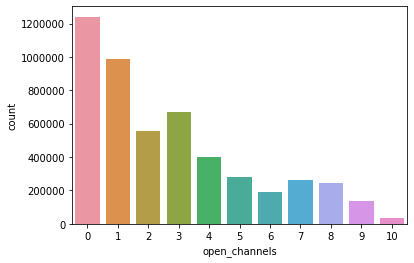

In [37]:
# Data distribution
sns.countplot(x='open_channels', data=data)
plt.show()

* The pandas correlation function used shows there is an 80.16 % correlation between signal and open_channels, hence we can predict open_channels from signal.
* The countdown plot show the data is imbalanced, with very few records for 10 open channels and 0 open channels having more than 1.2 million records.

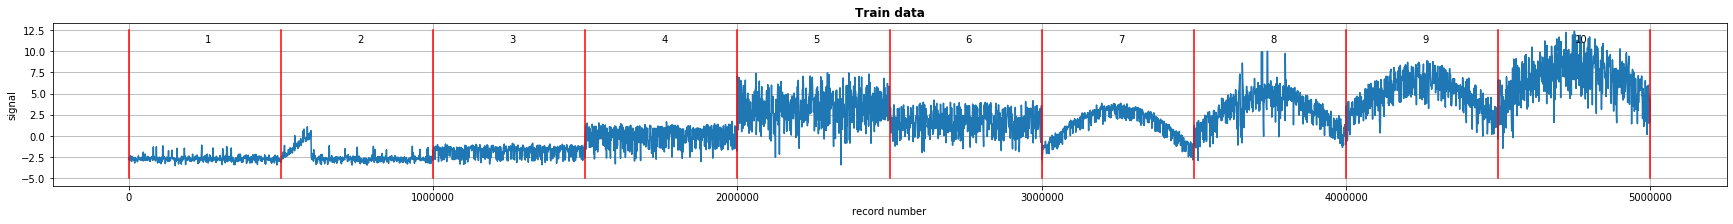

In [38]:
# visualising data, showing the various batches.. Inspired by Chris Doette's kernel
plt.figure(figsize=(30, 3))
plt.plot(range(0, 5000000, 1000), data.signal[::1000])
for i in range(0, 11):
    plt.plot([i*500000, i*500000], [-5, 12.5], 'r')
for j in range(0, 10):
    plt.text((j*500000) + 250000, 11, str(j+1))
plt.xlabel('record number')
plt.ylabel('signal')
plt.grid()
plt.title('Train data', fontweight='bold')
plt.show()

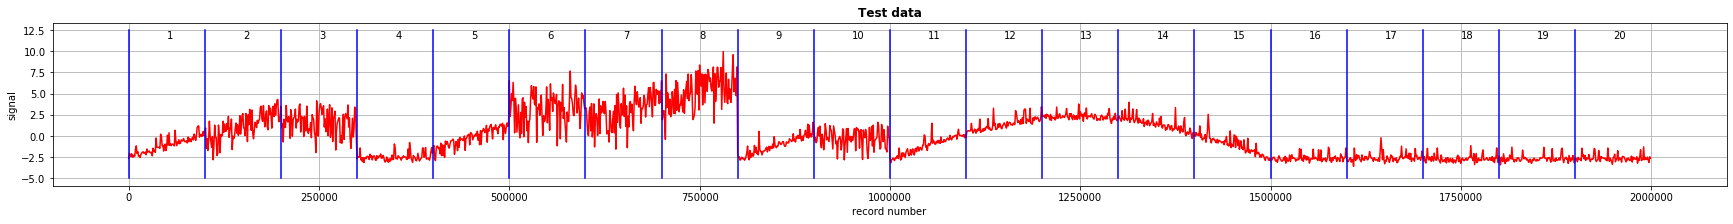

In [39]:
# visualising test data
plt.figure(figsize=(30, 3))
plt.plot(range(0, Test_data.shape[0], 1000), Test_data.signal[::1000], 'r')
for i in range(20):
    plt.plot([i*100000, i*100000], [-5, 12.5], 'b')
for j in range(20):
    plt.text((j*100000)+50000, 11.5, str(j+1))
plt.grid()
plt.xlabel('record number')
plt.ylabel('signal')
plt.title('Test data', fontweight='bold')
plt.show()

## Discussion
* Looking at the plots for train data and test data, we can see that the train data can be compartmentalised in batches of 500000, this can enable us treat the various types of drifts (linear and parabolic)
* However, compartmentalizing the test data in batches of 500000 doesn't help us all through. Batches with linear drifts can be handled with 100000 batches while the parabolic drift spans through 5 batches of 100000.
* We therefore write a function, that compartmentalizes the various datasets in small batches which contain each kind of drifts in a nice way.

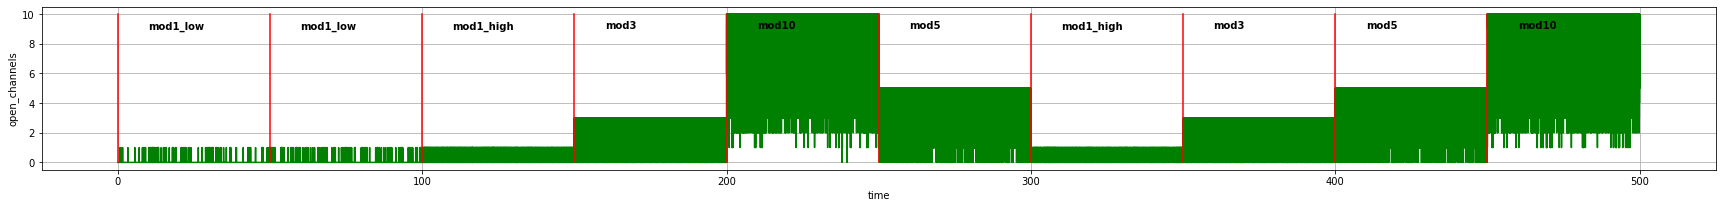

In [40]:
# plotting signal aggainst open_channels
plt.figure(figsize=(30, 3))
plt.plot(data['time'], data['open_channels'], 'g')
for idx, model in zip(range(10), ['mod1_low', 'mod1_low', 'mod1_high', 'mod3', 'mod10', 'mod5',
                                  'mod1_high', 'mod3', 'mod5', 'mod10']):
    plt.plot([idx*50, idx*50], [0, 10], 'r')
    plt.text((idx*50)+10, 9, model, fontweight='bold')

plt.xlabel('time')
plt.ylabel('open_channels')
plt.grid()
plt.show()

* From the above plot, we can see that there are signals that produced only one 1 channel and were either of low probability (batches 1 and 2) or high probability batches 3 and 7.
* we also see some signals could produce upto 3 open channels (batches 4 and 8) and some up to 5 open channels (batches 6 and 9)
* Lastly some signals could produce upto 10 open channels batches (5 and 10)

In [41]:
def batch_maker(data, df_type):
    batch = []
    size = [500000, 100000]
    if df_type == 'Train':
        for i in range(10):
            batch.append(data[i*size[0]: (i+1)*size[0]])
    else:
        for i in range(10):
            batch.append(data[i*size[1]: (i+1)*size[1]])
        for i in range(2):
            start = size[1]*10
            batch.append(data[start + i*size[0] : start + (i+1)*size[0]])
        
    return batch
df_train = batch_maker(data, 'Train')
df_test = batch_maker(Test_data, 'Test')


        
        

## Removing parabola drift with sine function.
This part is inspired by Eunho Lees's notebook [here](https://www.kaggle.com/eunholee/remove-drift-using-a-sine-function). However, i made some slight changes. For a better explanation of the equations used to arrive at the values of a, c, d, please look at his notebook and the comments below to fill in gaps you may have.
* Note that here i use y = a*sin(bx + c) + d as my sine equation. After getting the parameters a and c, i used these exact parameters to take out parabola drift. This is the main difference between my notebook and his.

In [42]:
def my_sin(data, a, c, d):
    # notice that the parabolas are just half way of a full sine wave hence half period,
    # hence we multipy period by 2. The period per batch is 50s
    x = data['time'].values
    b = (2 * np.pi) / (2 * 50)
    return a * np.sin(b*x + c) 


def parabola_param(data):
    x = data['time']
    y = data['signal'].values

    b = (2 * np.pi) / (2 * 50)
    M = np.array([[np.sin(b * t), np.cos(b * t), 1] for t in x])
    y = y.reshape(-1, 1)

    theta, residual, rank, singular = np.linalg.lstsq(M, y, rcond=None)
    
    a = np.sqrt(theta[1, 0]**2 + theta[0, 0]**2)
    c = math.atan2(theta[1, 0], theta[0, 0])
    d = theta[2, 0]

    return a, c, d

print(parabola_param(df_train[9]))

def remove_drift(data, dataset = 'train'):
    if dataset == 'train':
        for idx in [6, 7, 8, 9]:
            a, c , d = parabola_param(data[idx])
            data[idx].loc[:, 'signal'] = data[idx].loc[:, 'signal'].values - my_sin(data[idx], a, c, d)
    else:
        for idx in [10]:
            a, c , d = parabola_param(data[idx])
            data[idx].loc[:, 'signal'] = data[idx].loc[:, 'signal'].values - my_sin(data[idx], a, c, d)
    return data

df_train = remove_drift(df_train, 'train')
df_test = remove_drift(df_test, 'test')



(5.074016308177282, 3.1360194015343916, 3.263836977163787)


/Users/fritzpeleke/opt/anaconda3/envs/Tenv/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/fritzpeleke/opt/anaconda3/envs/Tenv/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


/Users/fritzpeleke/opt/anaconda3/envs/Tenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/fritzpeleke/opt/anaconda3/envs/Tenv/lib/python3.6/site-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/Users/fritzpeleke/opt/anaconda3/envs/Tenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

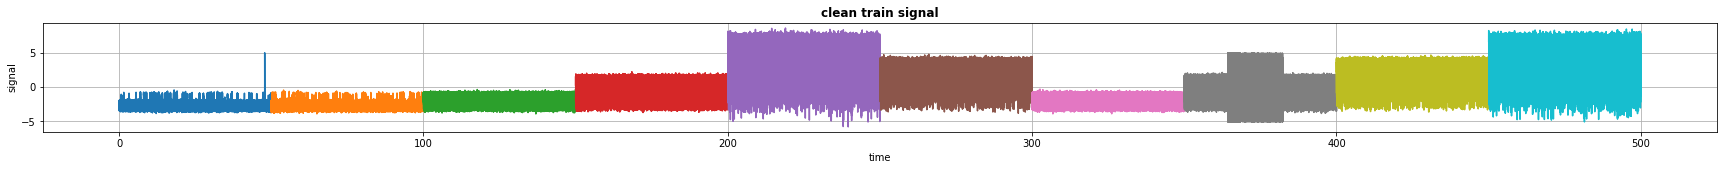

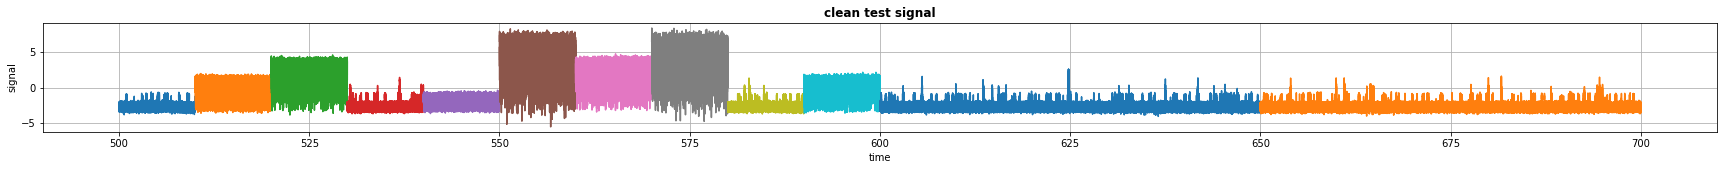

In [43]:
def lin_fun(x, m, c):
    return m*(x - c)

def lin_param(data):
    x = data['time']
    y = data['signal']
    
    popt, pcov = curve_fit(lin_fun, x, y)
    
    return popt[0], x.values[0:1]

def rem_slant_drift(data, dataset ='train'):
    if dataset == 'train':
        m, c = lin_param(data[1][0:100000])
        data[1].signal[0:100000] = data[1].signal[0:100000].values - lin_fun(data[1].time[0:100000].values, m, c)
    

    else:
        for idx in [0, 1, 4, 6, 7, 8]:
            m, c = lin_param(data[idx])
            data[idx].signal = data[idx].signal.values - lin_fun(data[idx].time.values, m, c)
    return data

        
df_train = rem_slant_drift(df_train, 'train')
df_test = rem_slant_drift(df_test, 'test')



plt.figure(figsize=(30, 2))
for idx in range(10):
    plt.plot(df_train[idx]['time'], df_train[idx]['signal'])
plt.title('clean train signal', fontweight='bold')
plt.xlabel('time')
plt.ylabel('signal')
plt.grid()
plt.show()

plt.figure(figsize=(30, 2))
for idx in range(12):
    plt.plot(df_test[idx]['time'], df_test[idx]['signal'])
plt.title('clean test signal', fontweight='bold')
plt.xlabel('time')
plt.ylabel('signal')
plt.grid()
plt.show()

In [44]:
clean_train_data = pd.concat(df_train)
clean_test_data = pd.concat(df_test)

X = clean_train_data.signal.values.astype(np.float32).reshape(-1, 1)
y = clean_train_data.open_channels.values.astype(np.int32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_train)
X_train = X_train.reshape(-1, 1, 1)
X_valid = X_valid.reshape(-1, 1, 1)
print(X_train.shape)

(4000000, 1, 1)


In [ ]:
model = tf.keras.Sequential()
model.add(Conv1D(32, 1, activation='relu', input_shape=[1, 1]))
model.add(Conv1D(32, 1, activation='relu'))
model.add(Conv1D(32, 1, activation='relu'))
model.add(Conv1D(32, 1, activation='relu'))
model.add(Conv1D(32, 1, activation='relu'))

model.add(Flatten())
model.add(Dense(11, 'softmax'))

print(model.summary())

ES = EarlyStopping(monitor='val_loss', patience=3,
                   verbose=1, restore_best_weights=True)
LR = ReduceLROnPlateau(patience=2, verbose=1)
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train.ravel(), validation_split=0.1, batch_size=512, epochs=10,
                    callbacks=[ES, LR])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 32)             64        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 32)             1056      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 32)             1056      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 32)             1056      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 32)             1056      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)               

In [ ]:
pred = model.predict(X_valid)
y_pred = np.argmax(pred, axis=1)
f1 = f1_score(y_valid, y_pred, average='weighted')
print(f1)


In [3]:
import os
print(os.getcwd())

/Users/fritzpeleke
